In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Praha Prodej Byty

In [91]:
db_connection_str = "postgresql://localhost:5432/postgres"
db_connection = create_engine(db_connection_str)

query_props = "SELECT * FROM properties WHERE price_total IS NOT NULL;"
df = pd.read_sql(query_props, db_connection)

query_feats = "SELECT * FROM property_features;"
df_features = pd.read_sql(query_feats, db_connection)

print(f"Loaded {df.shape[0]} properties.")

Loaded 3573 properties.


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3573 entries, 0 to 3572
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        3573 non-null   int64         
 1   web_link                  3573 non-null   object        
 2   title                     3573 non-null   object        
 3   description               3573 non-null   object        
 4   category_sub              3573 non-null   object        
 5   price_total               3573 non-null   int64         
 6   currency                  3538 non-null   object        
 7   street                    3573 non-null   object        
 8   locality_region_id        3573 non-null   int64         
 9   district_id               3573 non-null   int64         
 10  municipality_id           3573 non-null   int64         
 11  latitude                  3573 non-null   float64       
 12  longitude           

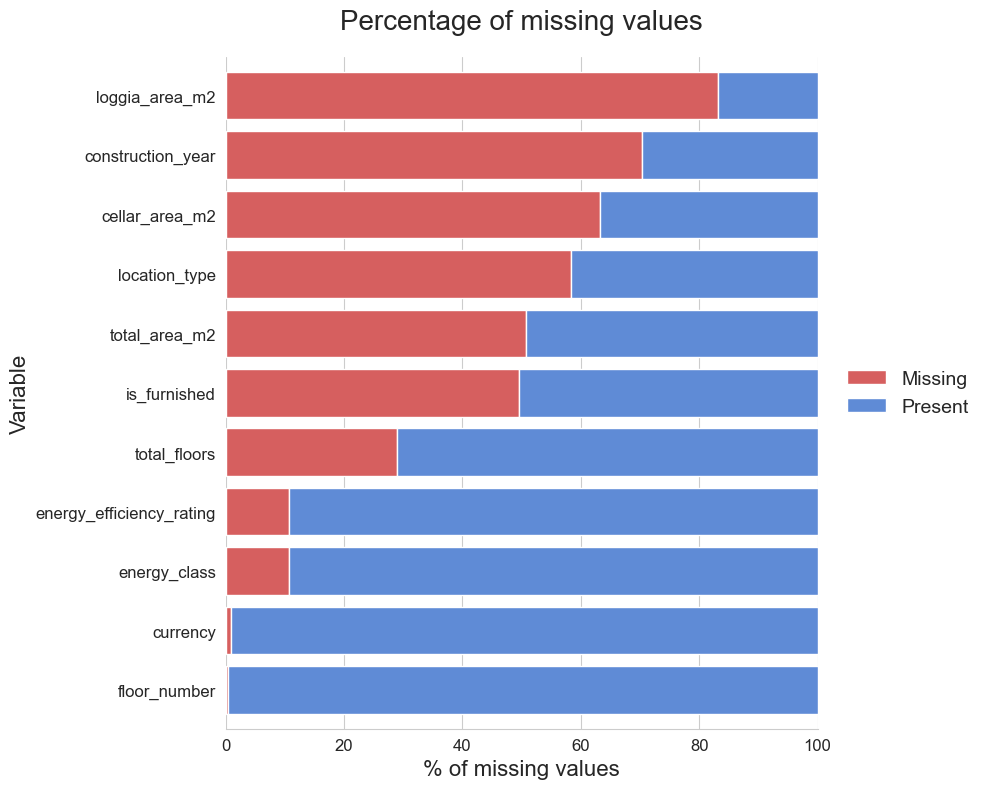

In [93]:
missing_series = df.isnull().mean() * 100

missing_data = missing_series[missing_series > 0]

missing_data = missing_data.sort_values(ascending=True)

plot_df = pd.DataFrame({
    'Missing': missing_data,
    'Present': 100 - missing_data
})

fig, ax = plt.subplots(figsize=(10, 8))

plot_df.plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=['#d65f5f', '#5f8bd6'], 
    width=0.8,
    edgecolor='white' 
)

ax.set_title('Percentage of missing values', fontsize=20, pad=20)
ax.set_xlabel('% of missing values', fontsize=16)
ax.set_ylabel('Variable', fontsize=16)

ax.legend(labels=['Missing', 'Present'], bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False, fontsize=14)

ax.set_xlim(0, 100)

ax.tick_params(axis='both', which='major', labelsize=12)

sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

* **Missing data handling:**

  * Missing values in the *loggia* field indicate that the property does not include a loggia.
  * The same assumption applies to the *cellar area* field; missing values imply the absence of a cellar.
  * Missing values in *usable area* are inferred from the *total area*, i.e., the usable area is assumed to be equal to the total area when not explicitly provided.
  * Missing values in the *currency* field occur for discounted properties; however, the *total price* remains correctly recorded in CZK.


In [94]:
df['currency'] = df['currency'].fillna('CZK')
df['loggia_area_m2'] = df['loggia_area_m2'].fillna(0.0)
df['cellar_area_m2'] = df['cellar_area_m2'].fillna(0.0)
df['total_area_m2'] = df['total_area_m2'].fillna(df['usable_area_m2'])

In [95]:
df.describe()

,id,price_total,locality_region_id,district_id,municipality_id,latitude,longitude,usable_area_m2,total_area_m2,loggia_area_m2,cellar_area_m2,floor_number,total_floors,construction_year,created_at
count,3.573000e+03,3.573000e+03,3573.0,3573.000000,3573.0,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3556.000000,2540.000000,1057.000000,3573
mean,2.147626e+09,1.243675e+07,10.0,4962.937587,3468.0,50.070822,14.444825,75.237615,81.860062,1.150854,1.431010,3.634421,6.400787,2005.496689,2025-12-22 05:00:25.970315776
min,1.758028e+06,7.950000e+05,10.0,47.000000,3468.0,49.948819,14.279461,16.000000,6.000000,0.000000,0.000000,1.000000,1.000000,30.000000,2025-12-22 04:57:39.828139
25%,1.059726e+09,7.997000e+06,10.0,5004.000000,3468.0,50.046362,14.402391,50.000000,51.000000,0.000000,0.000000,2.000000,4.000000,2001.000000,2025-12-22 04:58:59.804571904
50%,2.174485e+09,1.028462e+07,10.0,5005.000000,3468.0,50.071957,14.443644,66.000000,68.000000,0.000000,0.000000,3.000000,6.000000,2024.000000,2025-12-22 05:00:21.168506112
75%,3.206849e+09,1.425000e+07,10.0,5009.000000,3468.0,50.096235,14.488695,89.000000,93.000000,0.000000,2.000000,5.000000,8.000000,2026.000000,2025-12-22 05:01:59.098496
max,4.294919e+09,1.050000e+08,10.0,5010.000000,3468.0,50.167776,14.686194,428.000000,10270.000000,103.000000,65.000000,21.000000,26.000000,2028.000000,2025-12-22 05:03:19.777115
std,1.247730e+09,7.697301e+06,0.0,459.971369,0.0,0.036232,0.067123,40.046345,179.432567,3.518615,2.913182,2.511226,3.112819,67.932929,NaN


In [96]:
for col in df.select_dtypes(include=['int64']).columns:
    num_unique = df[col].nunique()
    print(f"Column '{col}' has {num_unique} unique values.")

Column 'id' has 3573 unique values.
Column 'price_total' has 1901 unique values.
Column 'locality_region_id' has 1 unique values.
Column 'district_id' has 11 unique values.
Column 'municipality_id' has 1 unique values.
Column 'usable_area_m2' has 226 unique values.


In [97]:
df["district_id"].value_counts()

district_id
5005    805
5004    618
5009    493
5010    445
5008    295
5006    220
5003    214
5001    171
5002    145
5007    136
47       31
Name: count, dtype: int64

In [98]:
for col in df.select_dtypes(include=['object']).columns:
    num_unique = df[col].nunique()
    print(f"Column '{col}' has {num_unique} unique values.")

Column 'web_link' has 3573 unique values.
Column 'title' has 1021 unique values.
Column 'description' has 3459 unique values.
Column 'category_sub' has 12 unique values.
Column 'currency' has 2 unique values.
Column 'street' has 1549 unique values.
Column 'construction_type' has 8 unique values.
Column 'building_condition' has 9 unique values.
Column 'ownership_type' has 3 unique values.
Column 'location_type' has 5 unique values.
Column 'energy_class' has 7 unique values.
Column 'energy_efficiency_rating' has 28 unique values.
Column 'is_furnished' has 3 unique values.
Column 'meta_description' has 3568 unique values.
Column 'updated' has 119 unique values.


In [99]:
energy_classes=df['energy_class'].value_counts()
energy_classes.sort_index()

energy_class
A     345
B    1138
C     496
D     322
E      99
F      47
G     742
Name: count, dtype: int64

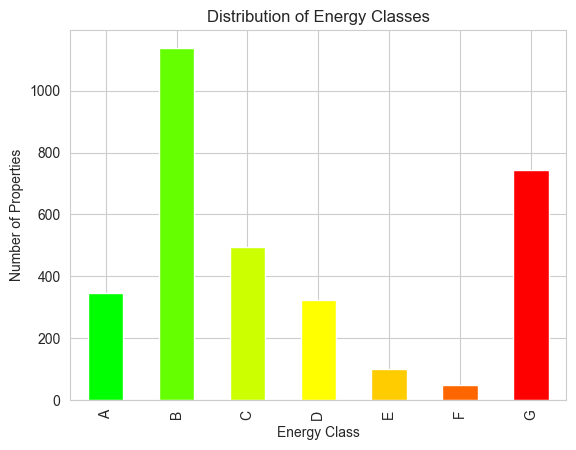

In [100]:
energy_gradient = {
    'A': '#00FF00',  # Bright Green
    'B': '#66FF00',  # Light Green
    'C': '#CCFF00',  # Yellow-Green
    'D': '#FFFF00',  # Yellow
    'E': '#FFCC00',  # Orange-Yellow
    'F': '#FF6600',  # Orange
    'G': '#FF0000',  # Red
    'Unknown': '#CCCCCC'  # Gray for unknown
}
energy_classes.sort_index().plot(kind='bar', color=[energy_gradient.get(cls, '#000000') for cls in energy_classes.sort_index().index])
plt.title('Distribution of Energy Classes')
plt.xlabel('Energy Class')
plt.ylabel('Number of Properties')
plt.show()

In [101]:
top_streets = df['street'].value_counts().head(40)
top_streets


street
Nádražní, Praha 5 - Smíchov                  62
Komárkova, Praha 4 - Chodov                  57
Vosátkova, Praha - Kamýk                     54
Wassermannova, Praha 5 - Hlubočepy           46
Hábova, Praha 5 - Stodůlky                   42
Silurská, Praha 5 - Hlubočepy                40
Vosátkova, Praha 4 - Kamýk                   25
Šiklové, Praha                               24
Kolbenova, Praha 9 - Vysočany                23
Zenklova, Praha 8 - Libeň                    19
Na kopečku, Praha 8 - Libeň                  18
Kutnohorská, Praha 10 - Dolní Měcholupy      17
Praha 5                                      17
Penízovková, Praha 10 - Pitkovice            15
Malešická, Praha 3 - Žižkov                  15
Praha 9                                      14
Holečkova, Praha 5 - Smíchov                 14
K Vinoři, Praha - Kbely                      13
Košická, Praha - Vršovice                    13
Honzíkova, Praha 10 - Dolní Měcholupy        13
Na vysoké I, Praha 5             

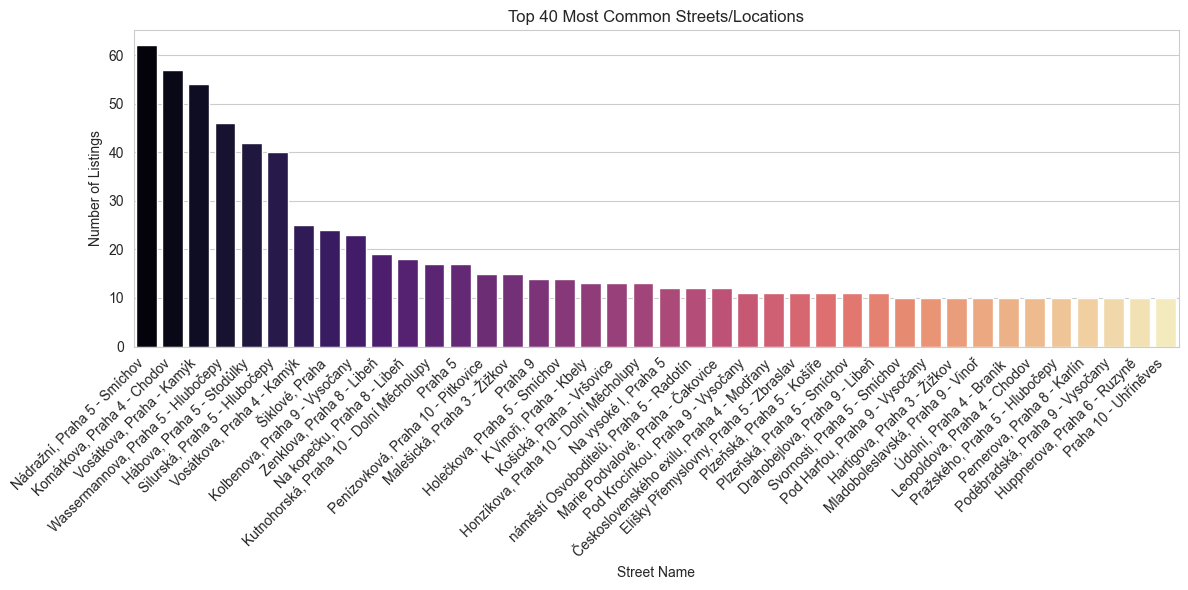

In [102]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_streets.index, 
    y=top_streets.values, 
    palette='magma' ,
    hue=top_streets.index
)

plt.title('Top 40 Most Common Streets/Locations')
plt.xlabel('Street Name')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

frequent locality can mean offers from Developer projects

weblinks are unique (added to see real listings)

In [103]:
df['currency'].value_counts()

currency
Kč     3538
CZK      35
Name: count, dtype: int64

currency is "Kč" in all cases

In [104]:
layout_counts = df['category_sub'].value_counts()
layout_counts.sort_index(inplace=True)
layout_counts

category_sub
1+1           73
1+kk         354
2+1          228
2+kk        1159
3+1          278
3+kk         889
4+1           79
4+kk         348
5+1           24
5+kk          79
6-a-vice      23
atypicky      39
Name: count, dtype: int64

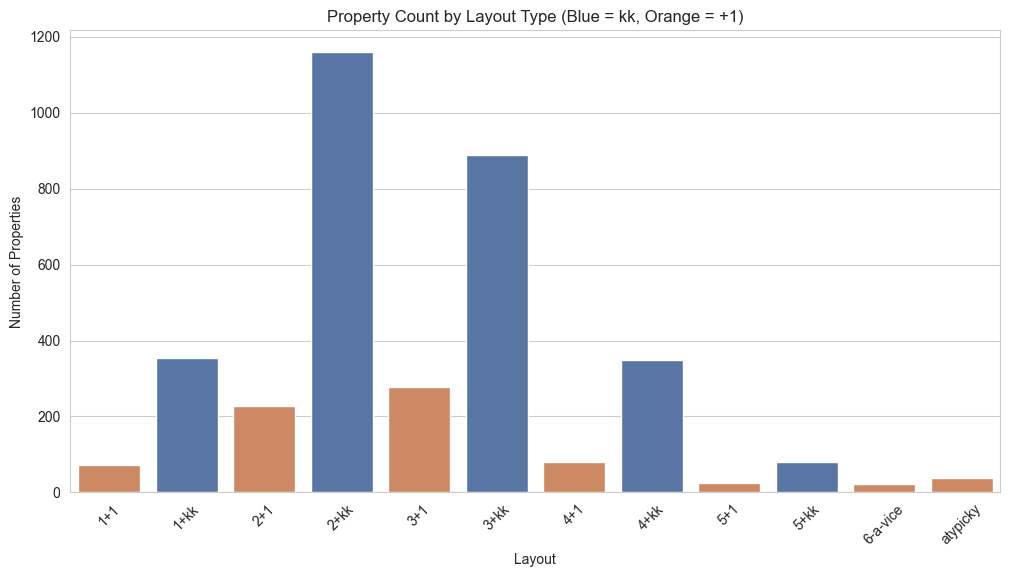

In [105]:
plt.figure(figsize=(12, 6))

colors = ['#4c72b0' if 'kk' in x else '#dd8452' for x in layout_counts.index]
sns.barplot(x=layout_counts.index, y=layout_counts.values, palette=colors,hue=layout_counts.index)
plt.title('Property Count by Layout Type (Blue = kk, Orange = +1)')
plt.xlabel('Layout')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.show()

In [106]:
df["usable_area_m2"].describe()

count    3573.000000
mean       75.237615
std        40.046345
min        16.000000
25%        50.000000
50%        66.000000
75%        89.000000
max       428.000000
Name: usable_area_m2, dtype: float64

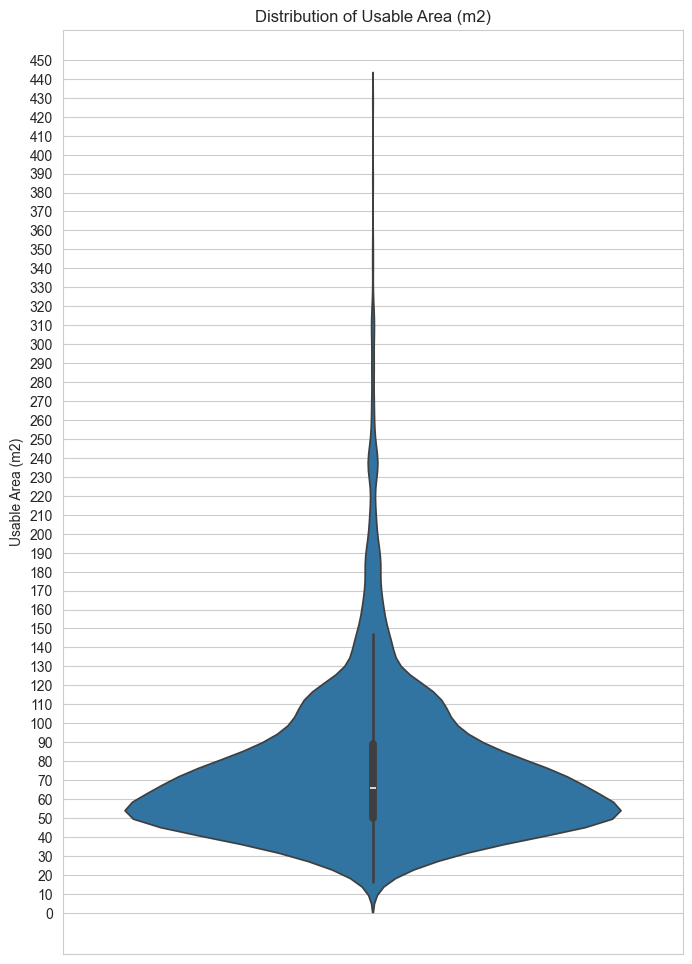

In [115]:
plt.figure(figsize=(8, 12))
sns.violinplot(y=df["usable_area_m2"])
plt.title('Distribution of Usable Area (m2)')
plt.ylabel('Usable Area (m2)')
plt.yticks(range(0, 460, 10)) 

plt.show()

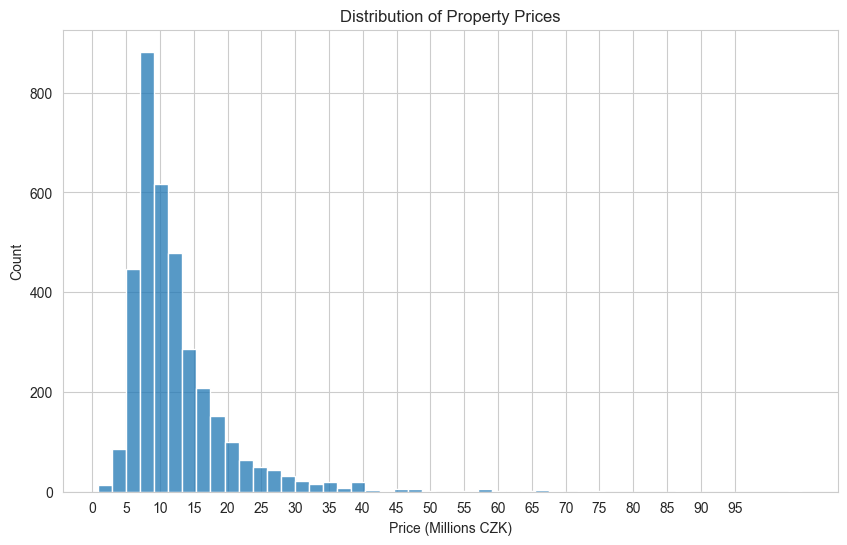

In [108]:
df['price_millions'] = df['price_total'] / 1_000_000

plt.figure(figsize=(10, 6))

sns.histplot(df['price_millions'], bins=50)

plt.title('Distribution of Property Prices')
plt.xlabel('Price (Millions CZK)')  
plt.ylabel('Count')

plt.xticks(range(0, 100, 5)) 

plt.show()



count    3573.000000
mean       12.436753
std         7.697301
min         0.795000
25%         7.997000
50%        10.284624
75%        14.250000
max       105.000000
Name: price_millions, dtype: float64


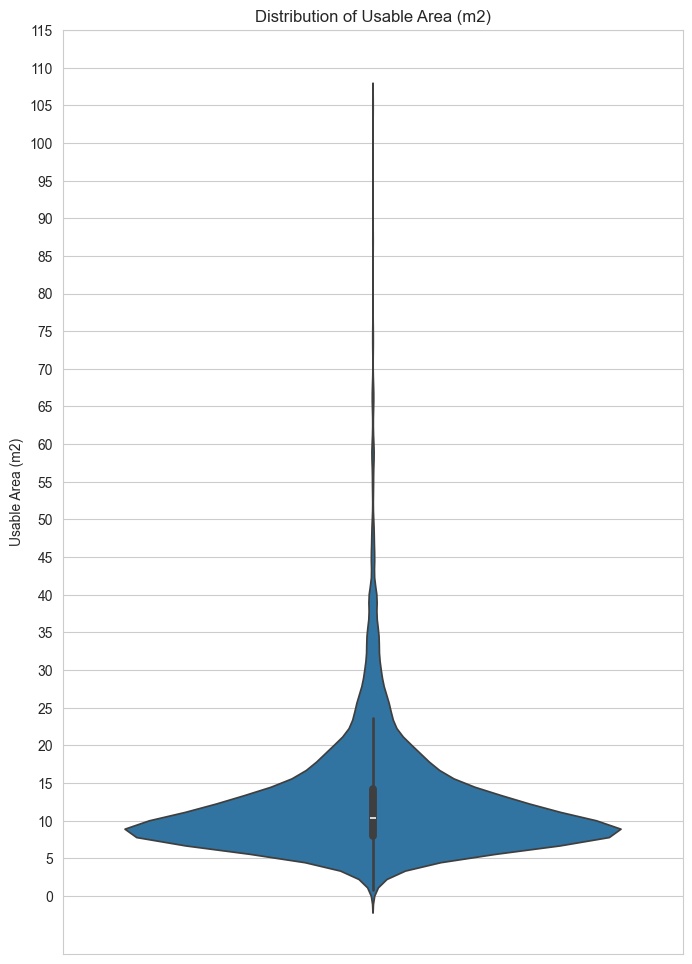

In [123]:
print(df["price_millions"].describe())
plt.figure(figsize=(8, 12))
sns.violinplot(y=df["price_millions"])
plt.title('Distribution of Usable Area (m2)')
plt.ylabel('Usable Area (m2)')
plt.yticks(range(0, 120, 5)) 

plt.show()

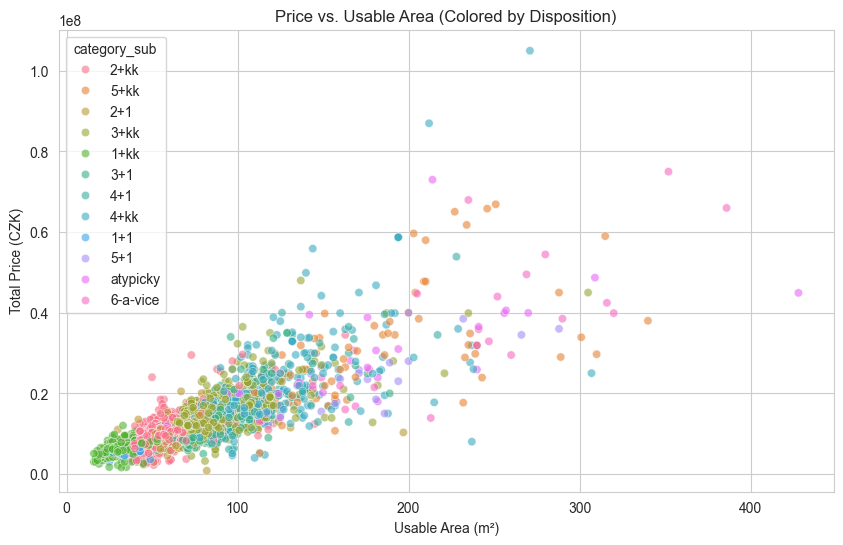

In [118]:
df["price_per_m2"] = df["price_total"] / df["usable_area_m2"]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='usable_area_m2', y='price_total', hue='category_sub', alpha=0.6)
plt.title('Price vs. Usable Area (Colored by Disposition)')
plt.xlabel('Usable Area (m²)')
plt.ylabel('Total Price (CZK)')
plt.show()


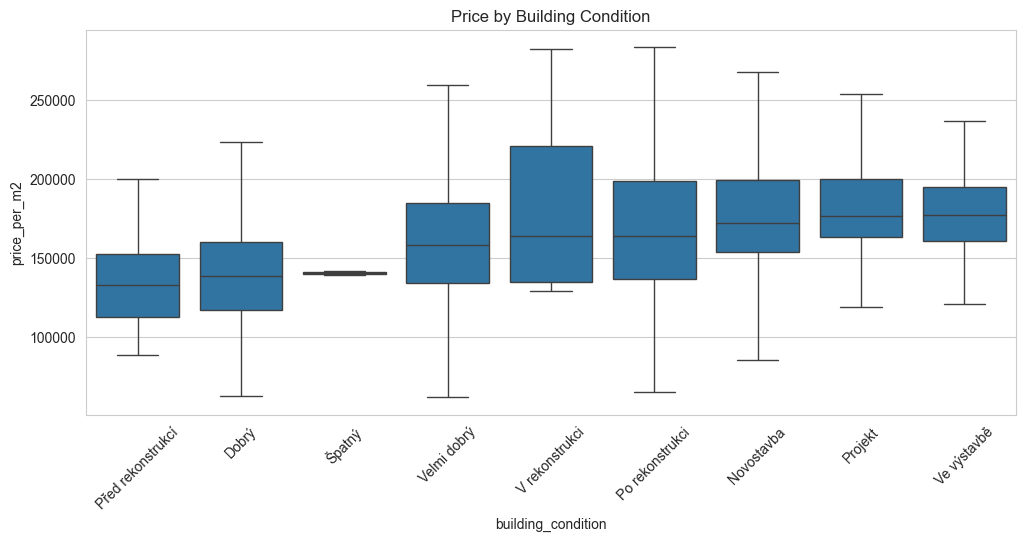

In [110]:
plt.figure(figsize=(12, 5))
sort_order = df.groupby('building_condition')['price_per_m2'].median().sort_values().index
sns.boxplot(data=df, x='building_condition', y='price_per_m2', order=sort_order, showfliers=False)
plt.xticks(rotation=45)
plt.title('Price by Building Condition')
plt.show()

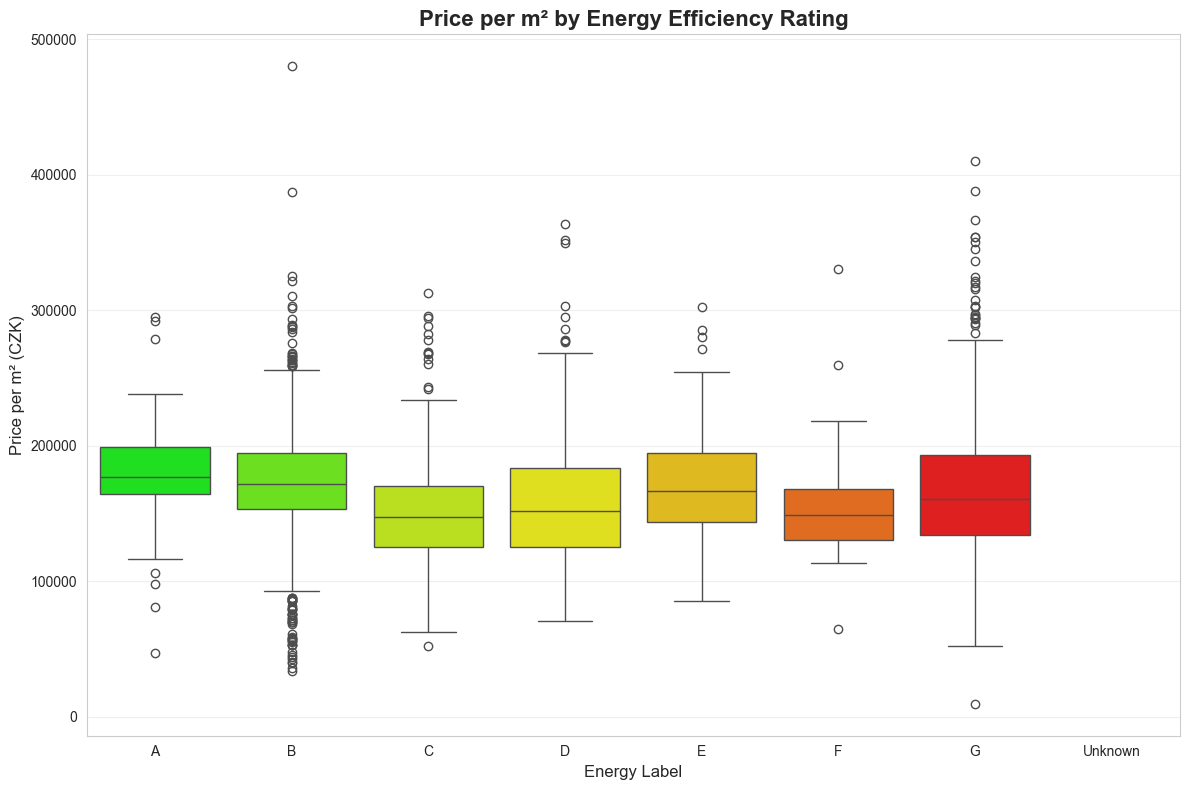

In [129]:
energy_gradient = {
    'A': '#00FF00',  # Bright Green
    'B': '#66FF00',  # Light Green
    'C': '#CCFF00',  # Yellow-Green
    'D': '#FFFF00',  # Yellow
    'E': '#FFCC00',  # Orange-Yellow
    'F': '#FF6600',  # Orange
    'G': '#FF0000',  # Red
    'Unknown': '#CCCCCC'  # Gray for unknown
}

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='energy_class', y='price_per_m2', 
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Unknown'],
            hue='energy_class', 
            palette=energy_gradient,
            legend=False
            )
plt.title('Price per m² by Energy Efficiency Rating', fontsize=16, fontweight='bold')
plt.xlabel('Energy Label', fontsize=12)
plt.ylabel('Price per m² (CZK)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

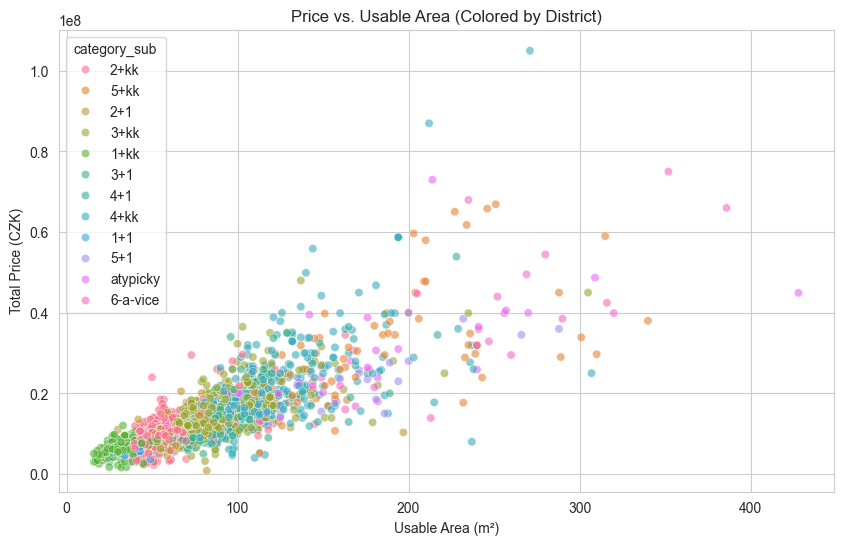

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='usable_area_m2', y='price_total', hue='category_sub', alpha=0.6)
plt.title('Price vs. Usable Area (Colored by Disposition)')
plt.xlabel('Usable Area (m²)')
plt.ylabel('Total Price (CZK)')
plt.show()

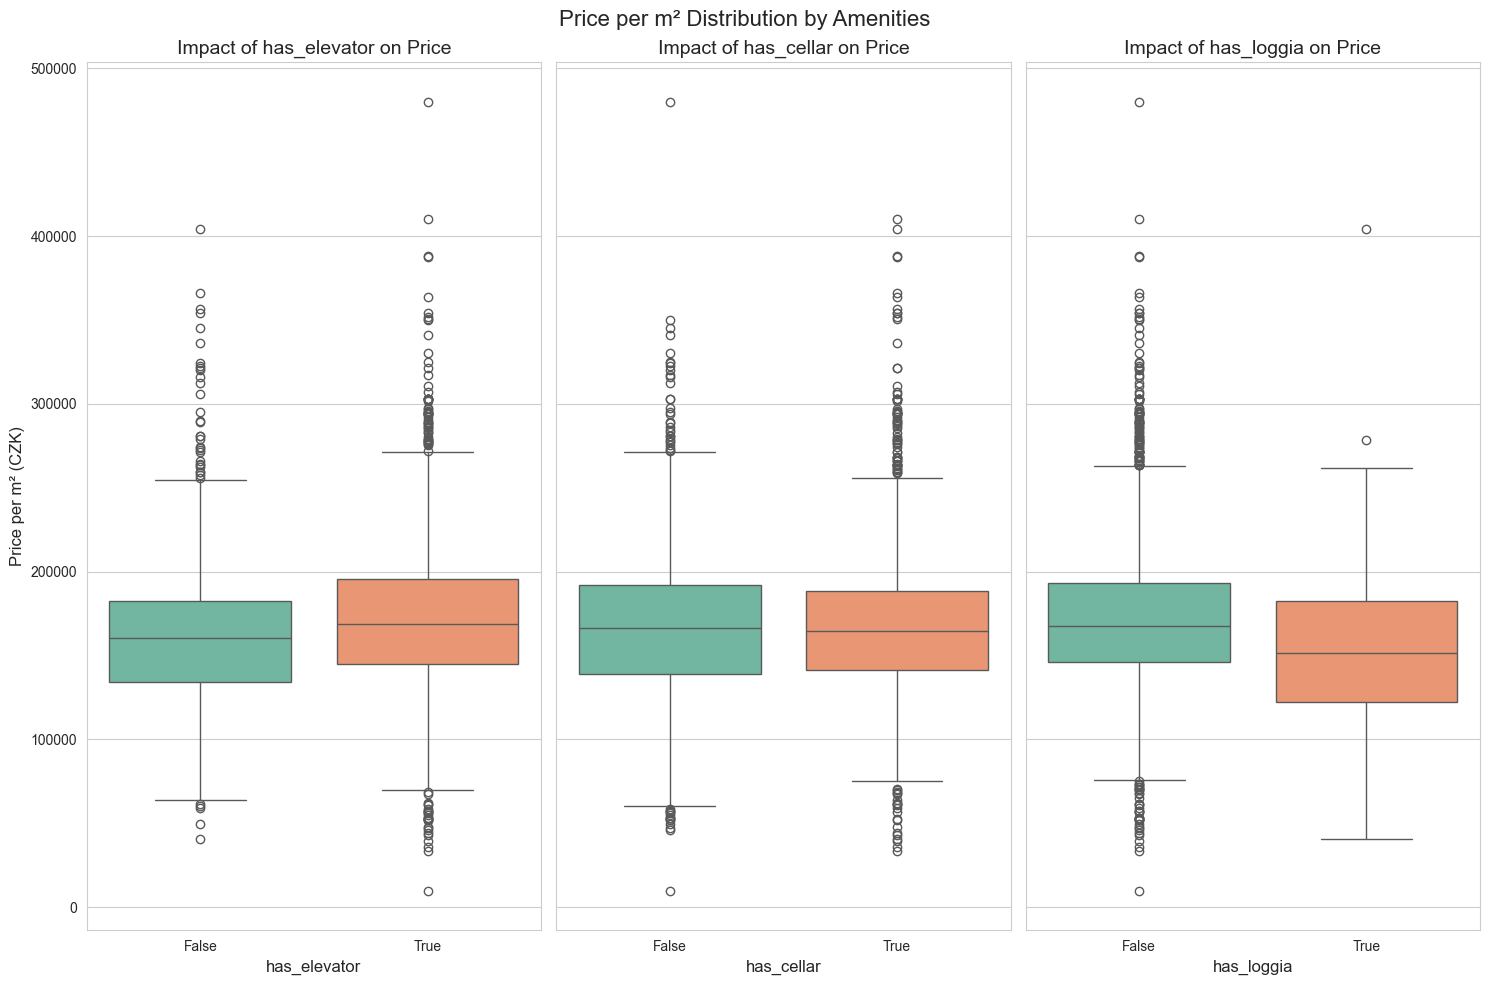

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)

amenities = ['has_elevator', 'has_cellar', 'has_loggia']

for i, col in enumerate(amenities):
    sns.boxplot(
        data=df, 
        x=col, 
        y='price_per_m2', 
        hue=col,            
        legend=False,       
        ax=axes[i], 
        palette='Set2'
    )
    
    # Formatting
    axes[i].set_title(f'Impact of {col} on Price', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    
    # Only show y-label for the first plot
    if i == 0:
        axes[i].set_ylabel('Price per m² (CZK)', fontsize=12)
    else:
        axes[i].set_ylabel('')

plt.suptitle('Price per m² Distribution by Amenities', fontsize=16)
plt.tight_layout()
plt.show()